# Anticipez les besoins en consommation électrique de bâtiments

Utiliser les données disponible sur https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking  pour prédire es consommations énérgétiques, ainsi que les émissions en CO2 pour la ville de Seattle

## Partie 2 :  Modélisation

### Quelques imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

import shap

# load JS visualization code to notebook
shap.initjs()


import warnings
sns.set()

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

warnings.filterwarnings('ignore')

### Récupération des dataframes cleanées
Pour rappel, on va effectuer notre modélisation que sur 2016, puis on va l'appliquer sur 2015 pour voir ce que ça donne

In [2]:
data = pd.read_feather('data/data_2016_cleaned.ft')
data15 = pd.read_feather('data/data_2015_cleaned.ft')

In [3]:
data.head()

,index,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUseWN(kBtu),TotalGHGEmissions,Building Age,Has steam,Has electricity,Has natural gaz
0,0,1.193014,-0.080793,1.298811,-0.420648,-1.163048,0.739382,-0.270312,1.041193,1.371822,1.257193,4.944492,0.017733,0.769475
1,1,1.193014,-0.080793,1.118874,2.176200,-1.163048,0.677373,-0.233229,1.174130,1.490171,-0.824179,-0.202245,0.017733,0.769475
2,2,1.193014,-0.080793,6.516962,2.869781,-1.163048,3.256895,-0.900711,3.073074,2.866052,-0.009729,4.944492,0.017733,0.769475
3,3,1.193014,-0.080793,0.938938,-0.420648,-1.163048,0.309936,-0.418641,0.978432,1.467415,1.287358,4.944492,0.017733,0.769475
4,4,1.193014,-0.080793,2.378428,2.558103,-1.163048,1.130582,0.285924,1.639705,1.866108,-0.341542,-0.202245,0.017733,0.769475


In [4]:
data.drop(columns=['index'], inplace=True)
data15.drop(columns=['index'], inplace=True)

In [5]:
# On définit 2 dataframes une pour éstimer  l'utilisation de l'énergie et une autre pour définir les émissions de gaz
GHG_data=data.drop(columns=['SiteEnergyUseWN(kBtu)','ENERGYSTARScore'])
energy_data=data.drop(columns=['TotalGHGEmissions','ENERGYSTARScore'])

# on définit aussi deux autres dataframe qui vont contenir le testing vs training score pour chacun de nos modèles
gaz_df = pd.DataFrame(columns=['Training', 'Testing'], index =['Linear', 'Ridge', 'Lasso', 'Random Forest', 'GradientBoosting', 'XGBoost', 'SVR']) 
energy_df = pd.DataFrame(columns=['Training', 'Testing'], index =['Linear', 'Ridge', 'Lasso', 'Random Forest', 'GradientBoosting', 'XGBoost', 'SVR']) 

### Utilisation d'une régression linéaire comme baseline

In [6]:
GHG_data.describe(include='all')

,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseType,LargestPropertyUseTypeGFA,TotalGHGEmissions,Building Age,Has steam,Has electricity,Has natural gaz
count,3.181000e+03,3.181000e+03,3.181000e+03,3.181000e+03,3.181000e+03,3.181000e+03,3.181000e+03,3.181000e+03,3.181000e+03,3.181000e+03,3.181000e+03
mean,-1.017245e-15,3.372028e-16,-1.002028e-15,-6.746324e-15,6.352109e-18,3.794513e-16,-2.411140e-16,2.591451e-16,4.558511e-16,1.059109e-15,-1.417777e-15
std,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00,1.000157e+00
min,-1.641880e+00,-1.134079e+00,-8.604245e-01,-4.206482e-01,-2.392782e+00,-2.485319e+00,-2.286002e+00,-1.397311e+00,-2.022453e-01,-5.639149e+01,-1.299587e+00
25%,-6.969152e-01,-8.079280e-02,-5.005520e-01,-4.206482e-01,-3.432251e-01,-7.444979e-01,-8.556326e-01,-8.543442e-01,-2.022453e-01,1.773317e-02,-1.299587e+00
50%,-2.244329e-01,-8.079280e-02,-1.406795e-01,-4.206482e-01,-3.432251e-01,-2.226721e-01,-1.691256e-02,-1.907182e-01,-2.022453e-01,1.773317e-02,7.694752e-01
75%,1.193014e+00,-8.079280e-02,3.925676e-02,-4.206482e-01,-3.579155e-02,5.590388e-01,6.871310e-01,6.237317e-01,-2.022453e-01,1.773317e-02,7.694752e-01
max,1.193014e+00,2.730465e+01,1.695326e+01,3.128312e+00,3.141022e+00,4.220043e+00,4.338202e+00,2.071643e+00,4.944492e+00,1.773317e-02,7.694752e-01


In [7]:
## on fait une fonction qui va effectuer la regression linéaire, stocker les résultats, et nous sortir les différentes erreurs
def print_interpolation_results(reg, raw_data, target, result_df=None, row=None):
    raw_data = raw_data.dropna(how='any')
    X_train, X_test, y_train, y_test = train_test_split(raw_data[list(set(raw_data.columns) - set([target]))] , raw_data[target], test_size=0.25)
    reg.fit(X_train, y_train)
    y_pred= reg.predict(X_test)
    print('MSE %f' % mean_squared_error(y_test, y_pred))
    print('RMSE %f' % np.sqrt(mean_squared_error(y_test, y_pred)))
    print('Testing Score %f' % reg.score(X_test, y_test))
    print('Training Score %f' % reg.score(X_train, y_train))
    
    if result_df is not None:
        result_df['Training'][row] = reg.score(X_train, y_train)
        result_df['Testing'][row] = reg.score(X_test, y_test)

    
    scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print("Cross val RMSE: {:.4f} +/- {:.4f}".format(np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))


In [8]:
# On fait la régression sur les émissions de Gaz
print_interpolation_results(LinearRegression(), GHG_data , 'TotalGHGEmissions', result_df=gaz_df, row='Linear')

MSE 0.277538
RMSE 0.526819
Testing Score 0.726248
Training Score 0.707918
Cross val RMSE: 0.5439 +/- 0.0193


In [9]:
# Puis sur l'utilisation énérgétique
print_interpolation_results(LinearRegression(), energy_data, 'SiteEnergyUseWN(kBtu)', result_df=energy_df, row='Linear')

MSE 0.314999
RMSE 0.561248
Testing Score 0.673732
Training Score 0.672440
Cross val RMSE: 0.5798 +/- 0.0193


### Utilisation des régressions Ridge / Lasso

In [10]:
# On utilise une fonction qui va nous permettre de récupérerle paramètre alpha optimal
def print_reduced_regression(reg, raw_data, target):
    raw_data = raw_data.dropna(how='any')
    X_train, X_test, y_train, y_test = train_test_split(raw_data[list(set(raw_data.columns) - set([target]))] , raw_data[target], test_size=0.25)
    n_alphas = 50
    alphas = np.logspace(-5, 5, n_alphas)
    coefs = []
    errors = []
    for a in alphas:
        reg.set_params(alpha=a)
        reg.fit(X_train, y_train)
        coefs.append(reg.coef_)
        errors.append(np.mean((reg.predict(X_test) - y_test) ** 2))
    fig, ax = plt.subplots(figsize=(20, 10))
    print('Optimal alpha for regression {}'.format(alphas[np.argmin(errors)]))
    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.title('Coefficients as a function of the regularization for ' + target)
    plt.axis('tight')
    plt.show()
    return alphas[np.argmin(errors)]
    

Optimal alpha for regression 54.286754393238596


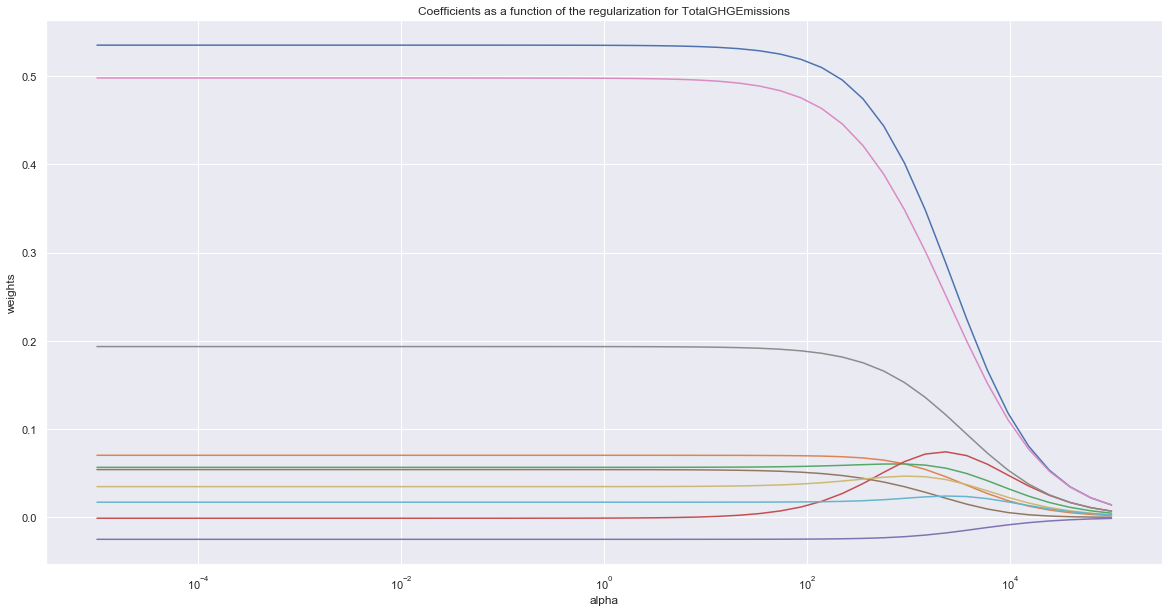

In [11]:
# on applique une régression ridge aux émissions de gaz
alpha = print_reduced_regression(Ridge(), GHG_data, 'TotalGHGEmissions')

In [12]:
print_interpolation_results(Ridge(alpha=alpha), GHG_data , 'TotalGHGEmissions', result_df=gaz_df, row='Ridge')

MSE 0.299653
RMSE 0.547406
Testing Score 0.685838
Training Score 0.720671
Cross val RMSE: 0.5376 +/- 0.0141


Optimal alpha for regression 1e-05


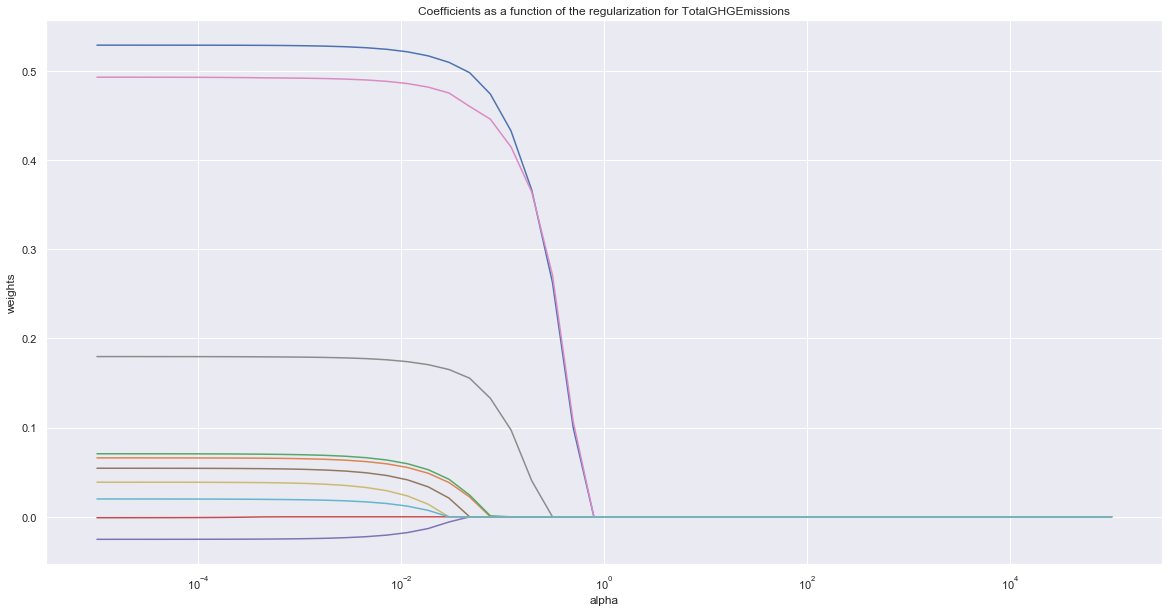

In [13]:
# Puis une régression Lasso
alpha = print_reduced_regression(Lasso(), GHG_data, 'TotalGHGEmissions')

In [14]:
print_interpolation_results(Lasso(alpha=alpha), GHG_data , 'TotalGHGEmissions', result_df=gaz_df, row='Lasso')

MSE 0.298661
RMSE 0.546499
Testing Score 0.697351
Training Score 0.717574
Cross val RMSE: 0.5347 +/- 0.0236


Optimal alpha for regression 138.9495494373139


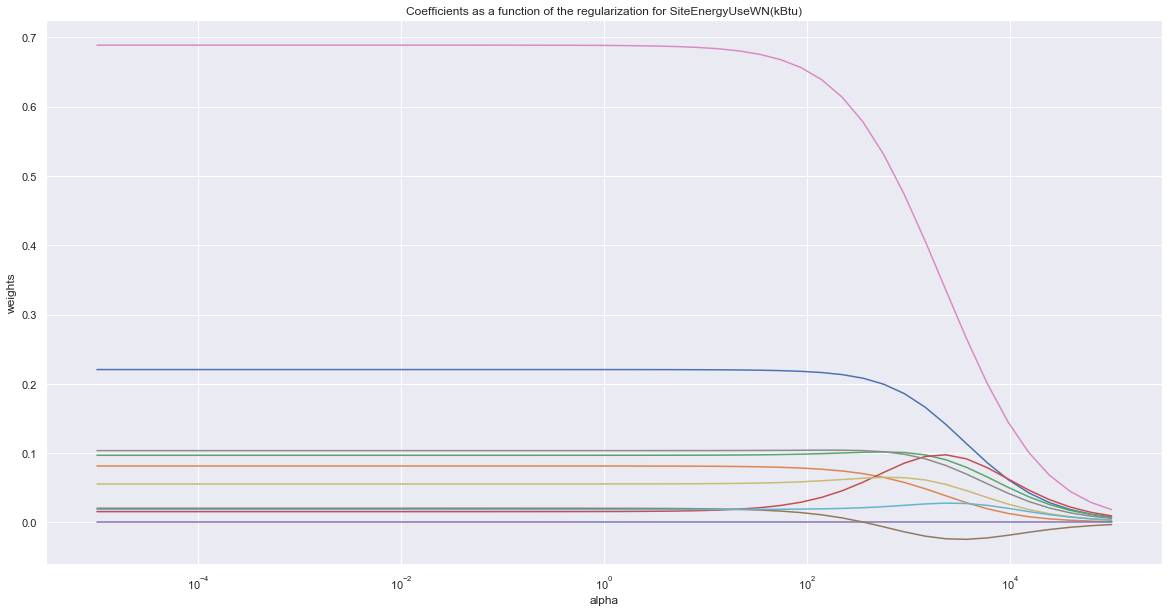

In [15]:
# On fait la même chose pour la consommation d'énérgie
alpha = print_reduced_regression(Ridge(), energy_data, 'SiteEnergyUseWN(kBtu)')

In [16]:
print_interpolation_results(Ridge(alpha=alpha), energy_data , 'SiteEnergyUseWN(kBtu)', result_df=energy_df, row='Ridge')

MSE 0.344689
RMSE 0.587102
Testing Score 0.645763
Training Score 0.680272
Cross val RMSE: 0.5724 +/- 0.0196


Optimal alpha for regression 0.004498432668969444


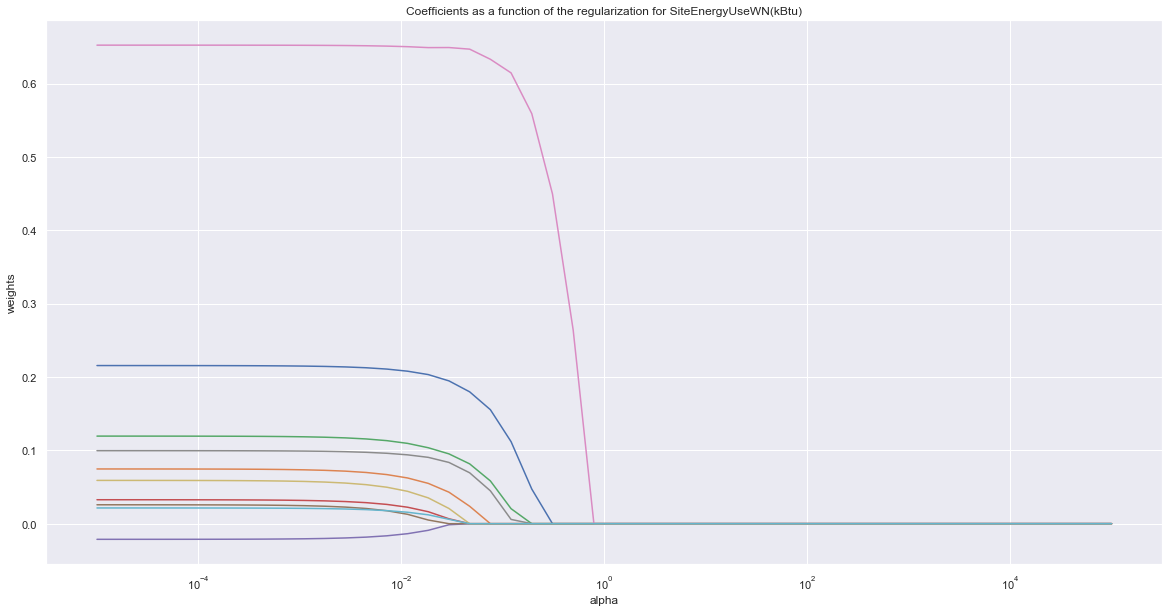

In [17]:
alpha = print_reduced_regression(Lasso(), energy_data, 'SiteEnergyUseWN(kBtu)')

In [18]:
print_interpolation_results(Lasso(alpha=alpha), energy_data , 'SiteEnergyUseWN(kBtu)', result_df=energy_df, row='Lasso')

MSE 0.329878
RMSE 0.574350
Testing Score 0.651127
Training Score 0.678972
Cross val RMSE: 0.5746 +/- 0.0306


### Utisation du Random Forest

In [20]:
def my_train_test_split(raw_data, target):
    raw_data = raw_data.dropna(how='any')
    return train_test_split(raw_data[list(set(raw_data.columns) - set([target]))] , raw_data[target], test_size=0.25)

# pour afficher la prédiction vs la valeur target
def print_regression_results(reg, X_train, X_test, y_train, y_test, color='green', result_df=None, row=None):
    y_pred= reg.predict(X_test)
    print('MSE %f' % mean_squared_error(y_test, y_pred))
    print('RMSE %f' % np.sqrt(mean_squared_error(y_test, y_pred)))
    print('Testing Score %f' % reg.score(X_test, y_test))
    print('Training Score %f' % reg.score(X_train, y_train))
    if result_df is not None:
        result_df['Training'][row] = reg.score(X_train, y_train)
        result_df['Testing'][row] = reg.score(X_test, y_test)
    plt.figure(figsize = (15,15))
    plt.title("Error over predictions")    
    plt.scatter(y_test.values, y_pred, color=color)
    plt.xlabel('Tests')
    plt.ylabel('Prediction')
    axes = plt.gca() 
    axes.set_xlim(0, max(max(y_test.values), max(y_pred)))
    axes.set_ylim(0, max(max(y_test.values), max(y_pred)))
    plt.show()

    
## pour afficher les résultats par estimateur
def plot_training_vs_test(results_df, is_for_energy):
    results_df = results_df.dropna(how='any')
    x = np.arange(len(results_df))
    fig, ax = plt.subplots(figsize=(15,10))
    if not is_for_energy:
        ax.bar(x - 0.2, results_df['Training'], 0.40, label='Training score', color='green')
        ax.bar(x + 0.2, results_df['Testing'], 0.40, label='Testing score', color='blue')
        plt.title('Scores par estimateurs pour la prédiction des émissions de gaz')
    else:
        ax.bar(x - 0.2, results_df['Training'], 0.40, label='Training score', color='coral')
        ax.bar(x + 0.2, results_df['Testing'], 0.40, label='Testing score', color='skyblue')
        plt.title('Scores par estimateurs pour la prédiction de consommation d\'énérgie')
        
    plt.xlabel('Modèle')
    plt.ylabel('R²')
    plt.xticks(x, results_df.index)


Pour le Random Forest, on commence d'abord par les émissions de gaz, et on faire un GridSearchCV avec validation croisée pour récupérer le meilleur estimateur

{'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200}
MSE 0.267906
RMSE 0.517597
Testing Score 0.726302
Training Score 0.780089


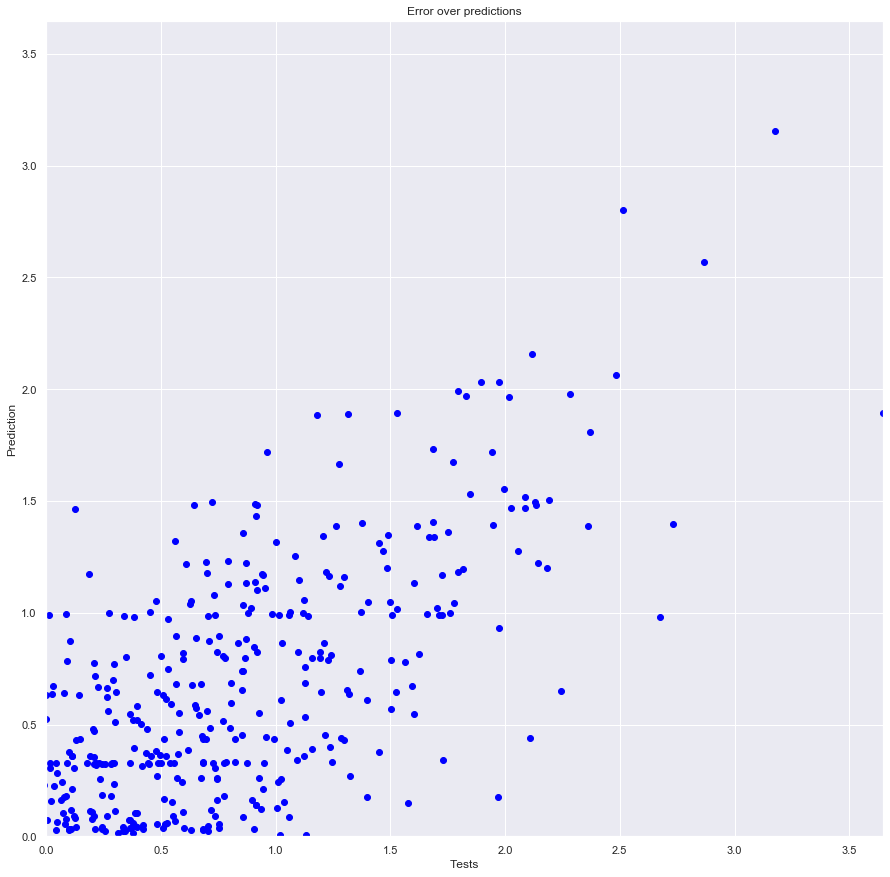

In [21]:
X_train, X_test, y_train, y_test = my_train_test_split(GHG_data , 'TotalGHGEmissions')

reg = RandomForestRegressor(random_state=42)
param_grid = {'bootstrap': [True],
              'max_depth': range(1,6),
              'min_samples_leaf': range(3,8),
              'min_samples_split': range(3,8),
              'n_estimators': [200]}
grid = GridSearchCV(reg, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print_regression_results(grid.best_estimator_, 
                         X_train, X_test, y_train, y_test, 
                         color='blue', result_df=gaz_df, row='Random Forest')

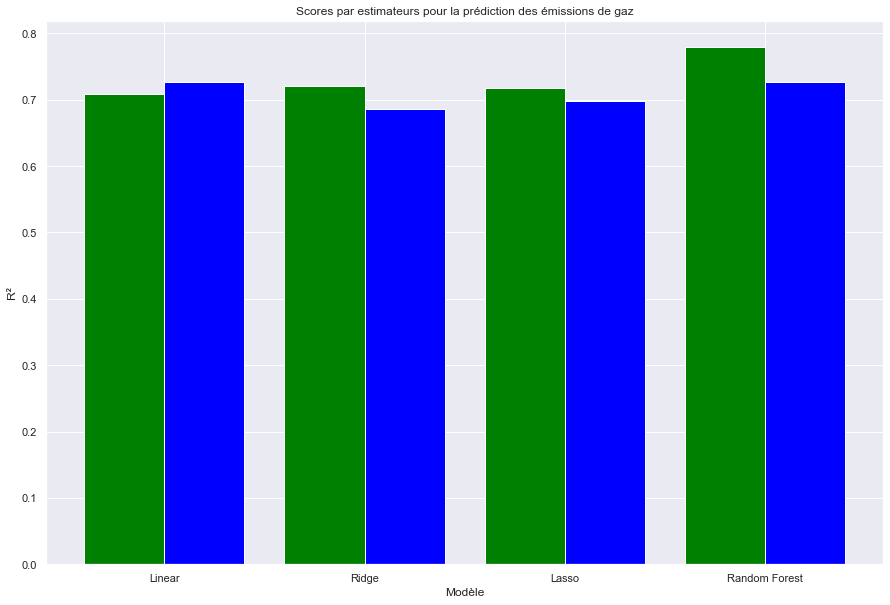

In [22]:
# On affiche les résultats par estimateur so far
plot_training_vs_test(gaz_df, False)

On va faire la même chose pour la consommation d'énérgie, à savoir une validation croisée

{'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 200}
MSE 0.270283
RMSE 0.519887
Testing Score 0.728610
Training Score 0.752026


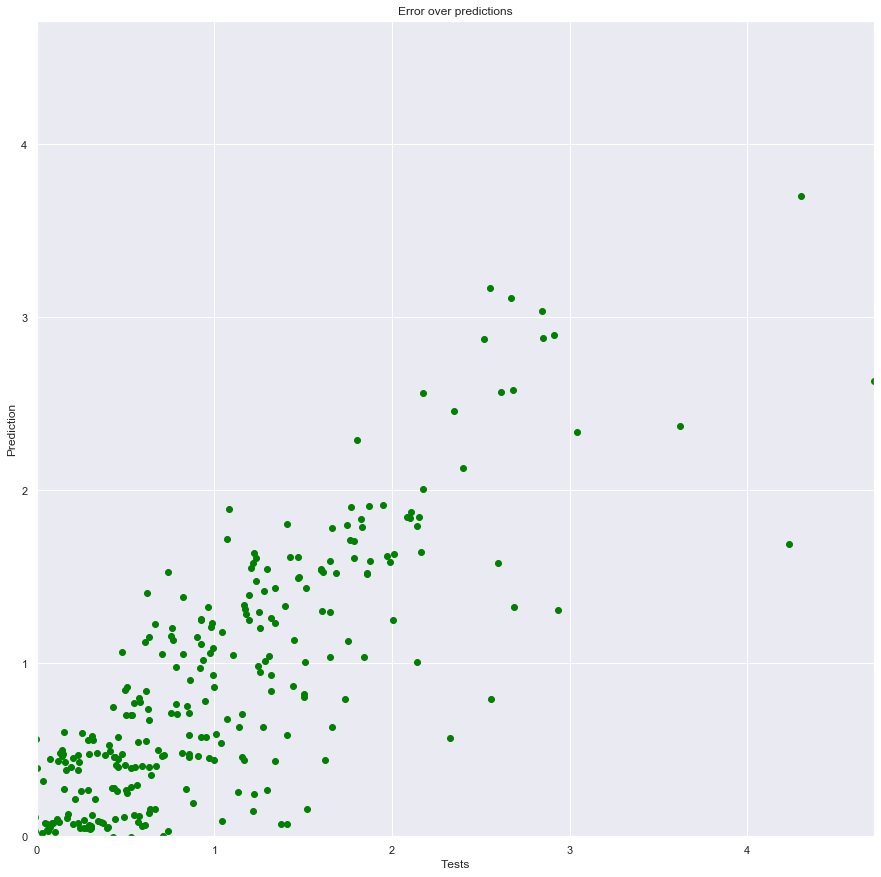

In [24]:
X_train, X_test, y_train, y_test = my_train_test_split(energy_data, 'SiteEnergyUseWN(kBtu)')

reg = RandomForestRegressor(random_state=42)
param_grid = {'bootstrap': [True],
              'max_depth': range(1,6),
              'min_samples_leaf': range(3,8),
              'min_samples_split': range(3,8),
              'n_estimators': [200]}
grid = GridSearchCV(reg, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print_regression_results(grid.best_estimator_,
                         X_train, X_test, y_train, y_test, 
                         color='green', result_df=energy_df, row='Random Forest')

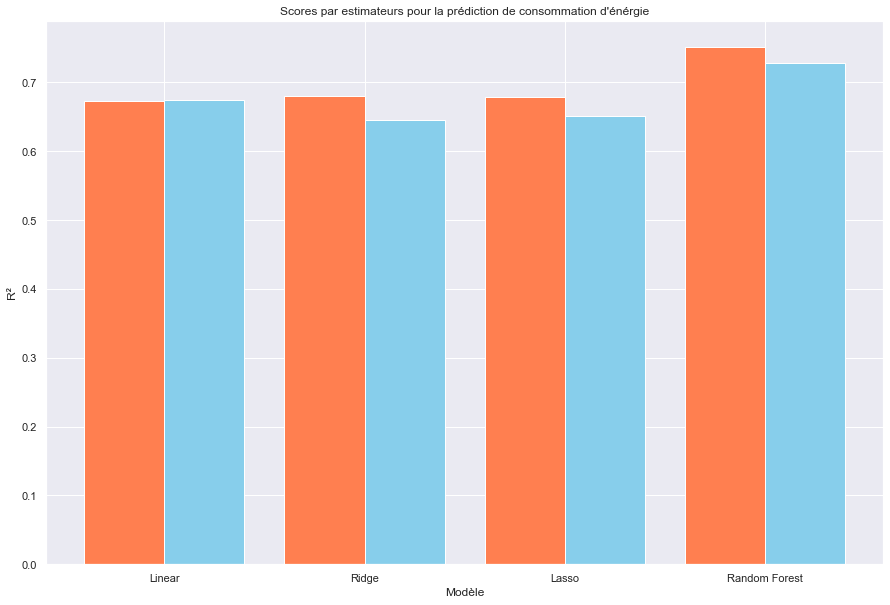

In [25]:
plot_training_vs_test(energy_df, True)

### Utilisation du Gradient boosting

{'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 200}
MSE 0.216567
RMSE 0.465368
Testing Score 0.777120
Training Score 0.849586


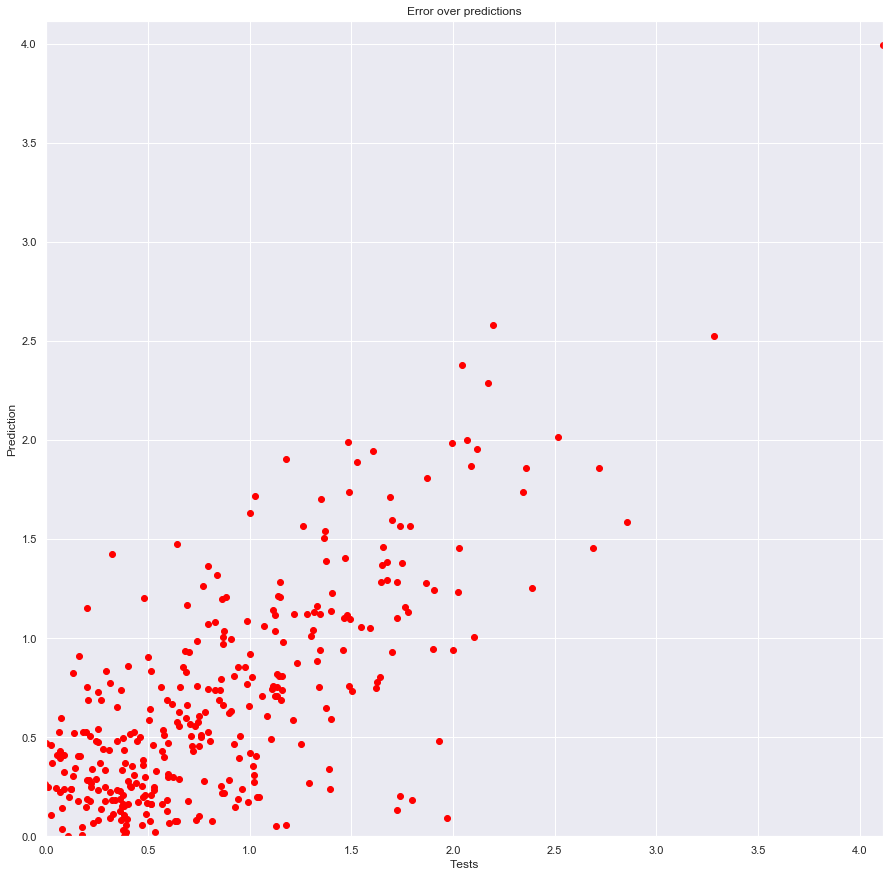

In [27]:
# on applique un gradient boosting cette fois ci, on commence encore une fois par le gaz, est toujours avec une validation croisée
X_train, X_test, y_train, y_test = my_train_test_split(GHG_data, 'TotalGHGEmissions')

reg = GradientBoostingRegressor(random_state=42)
param_grid = {'max_depth': range(2,5),
              'min_samples_leaf': range(3,8),
              'min_samples_split': range(3,8),
              'n_estimators': [200]}
grid = GridSearchCV(reg, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print_regression_results(grid.best_estimator_, 
                         X_train, X_test, y_train, y_test, 
                         color='red', result_df=gaz_df, row='GradientBoosting')

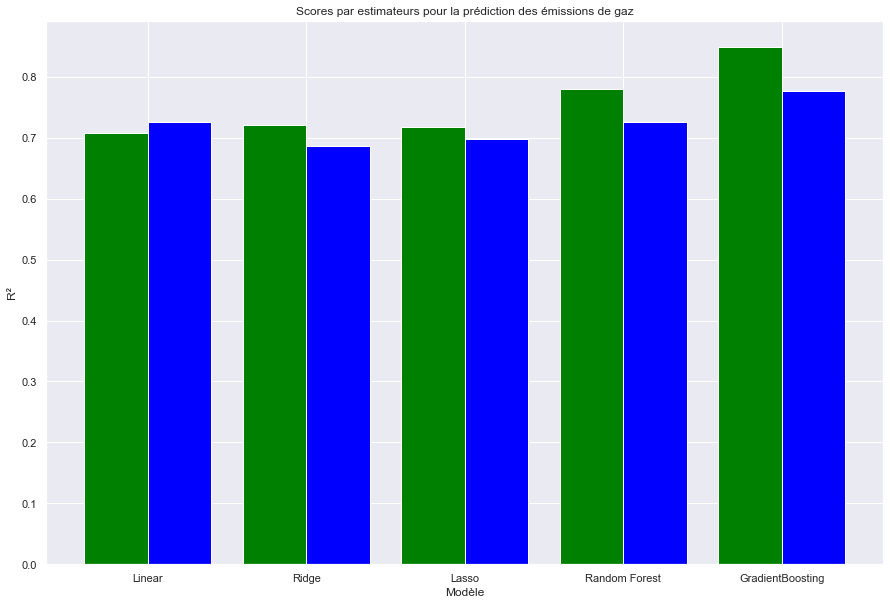

In [28]:
plot_training_vs_test(gaz_df, False)

{'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 200}
MSE 0.230293
RMSE 0.479888
Testing Score 0.774474
Training Score 0.844117


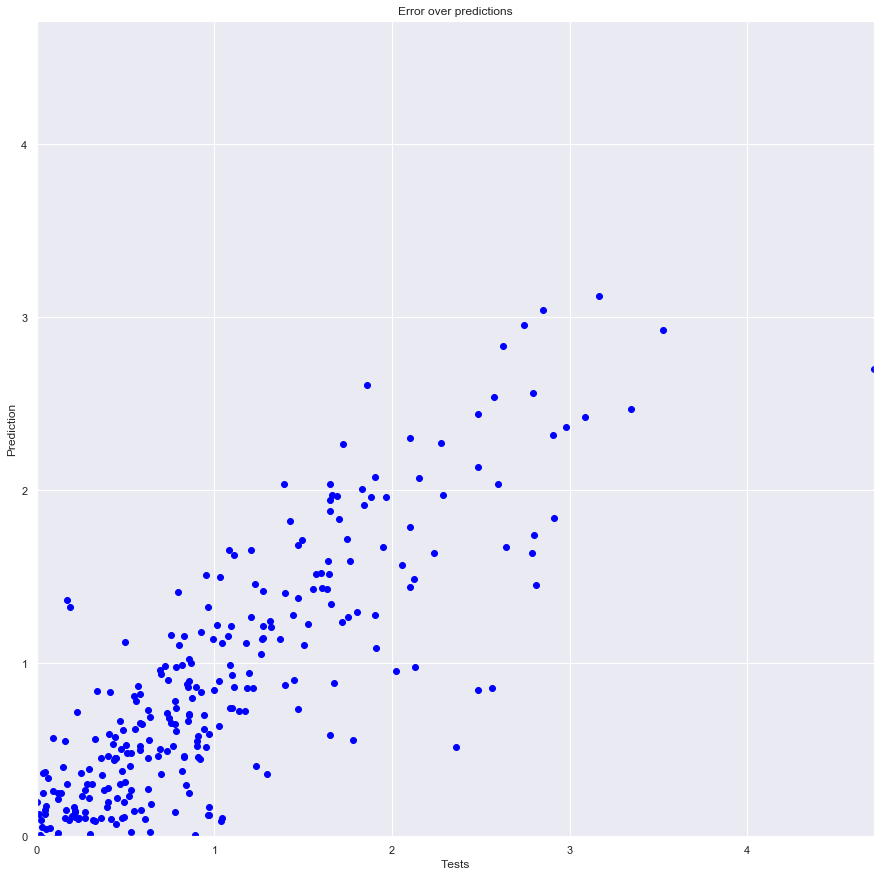

In [30]:
# en suite on fait ça pour l'énérgie
X_train, X_test, y_train, y_test = my_train_test_split(energy_data, 'SiteEnergyUseWN(kBtu)')

reg = GradientBoostingRegressor(random_state=42)
param_grid = {'max_depth': range(2,5),
              'min_samples_leaf': range(3,8),
              'min_samples_split': range(3,8),
              'n_estimators': [200]}
grid = GridSearchCV(reg, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print_regression_results(grid.best_estimator_,
                         X_train, X_test, y_train, y_test,
                         color='blue', 
                         result_df=energy_df, row='GradientBoosting')


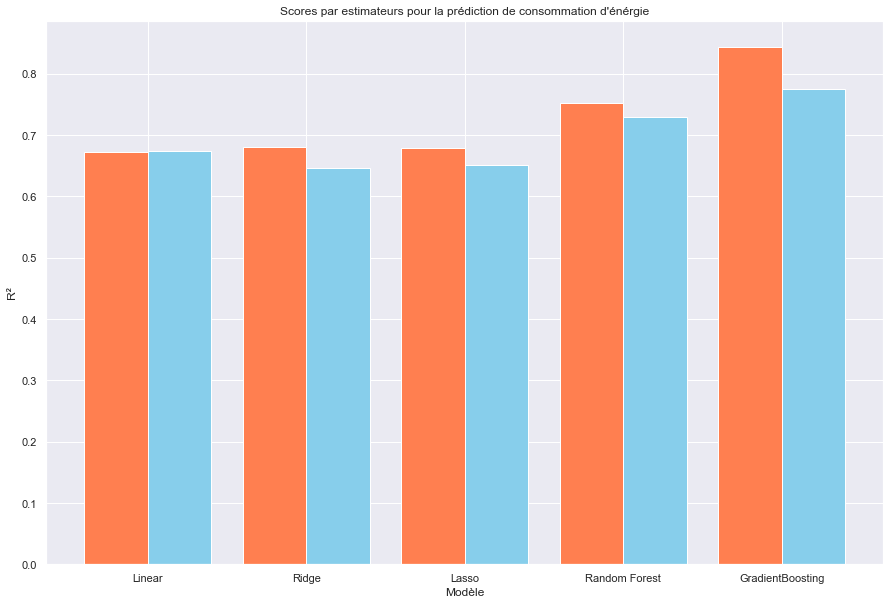

In [31]:
plot_training_vs_test(energy_df, True)

### Utilisation du SVR

{'C': 20.0, 'gamma': 0.01, 'kernel': 'rbf'}
MSE 0.262929
RMSE 0.512766
Testing Score 0.738915
Training Score 0.755089


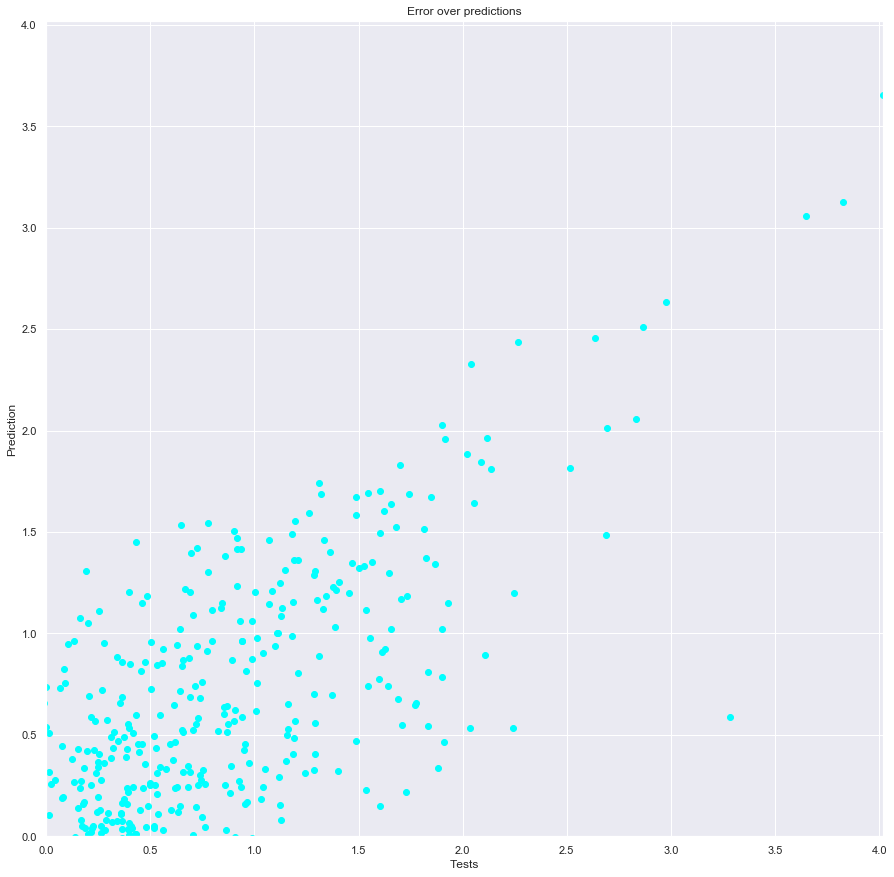

In [37]:
X_train, X_test, y_train, y_test = my_train_test_split(GHG_data, 'TotalGHGEmissions')

reg = SVR()
param_grid = {'C': np.linspace(10, 50, 5),  
              'gamma': np.logspace(-4,0,5), 
              'kernel': ['rbf']}  
grid = GridSearchCV(reg, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print_regression_results(grid.best_estimator_,
                         X_train, X_test, y_train, y_test, 
                         color='cyan', result_df=gaz_df, row='SVR')

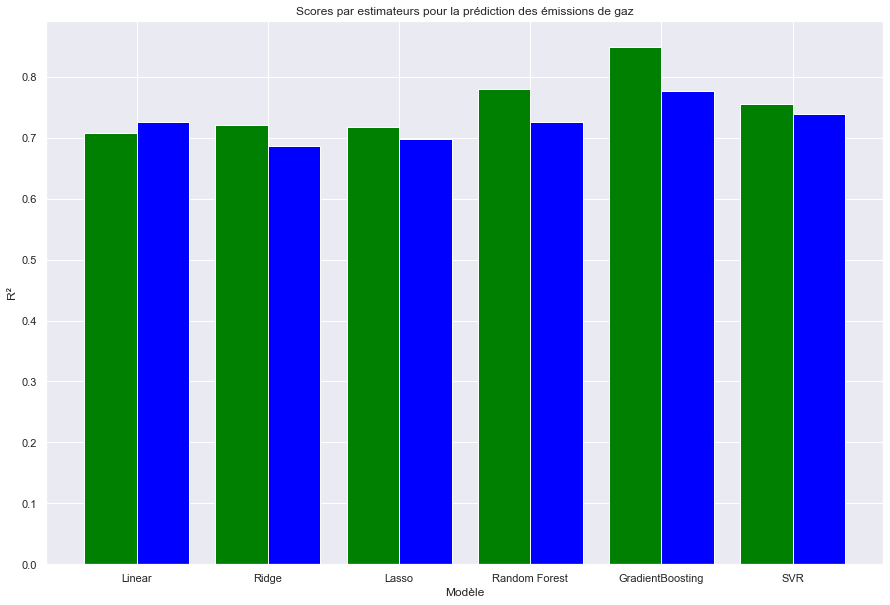

In [38]:
plot_training_vs_test(gaz_df, False)

{'C': 17.333333333333336, 'gamma': 0.01, 'kernel': 'rbf'}
MSE 0.287900
RMSE 0.536563
Testing Score 0.711721
Training Score 0.710290


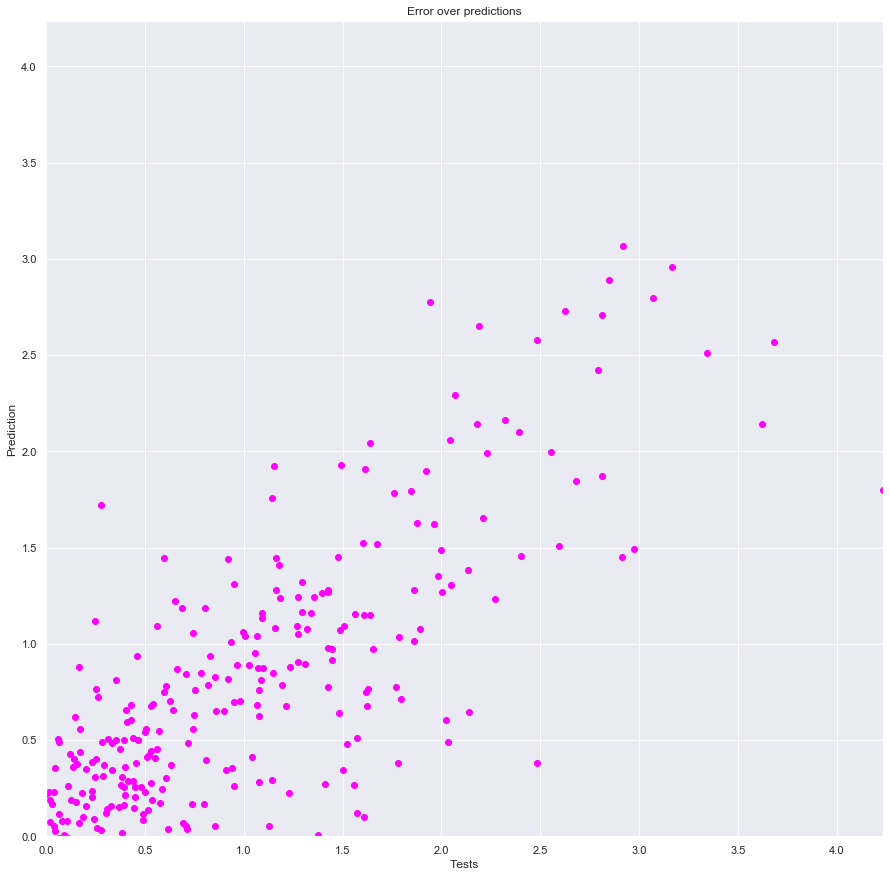

In [41]:
X_train, X_test, y_train, y_test = my_train_test_split(energy_data, 'SiteEnergyUseWN(kBtu)')

reg = SVR()
param_grid = {'C': np.linspace(1, 50, 10),  
              'gamma': np.logspace(-4,0,5), 
              'kernel': ['rbf']}  
grid = GridSearchCV(reg, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)
print(grid.best_params_)
print_regression_results(grid.best_estimator_,
                         X_train, X_test, y_train, y_test, 
                         color='magenta', 
                         result_df=energy_df, row='SVR')




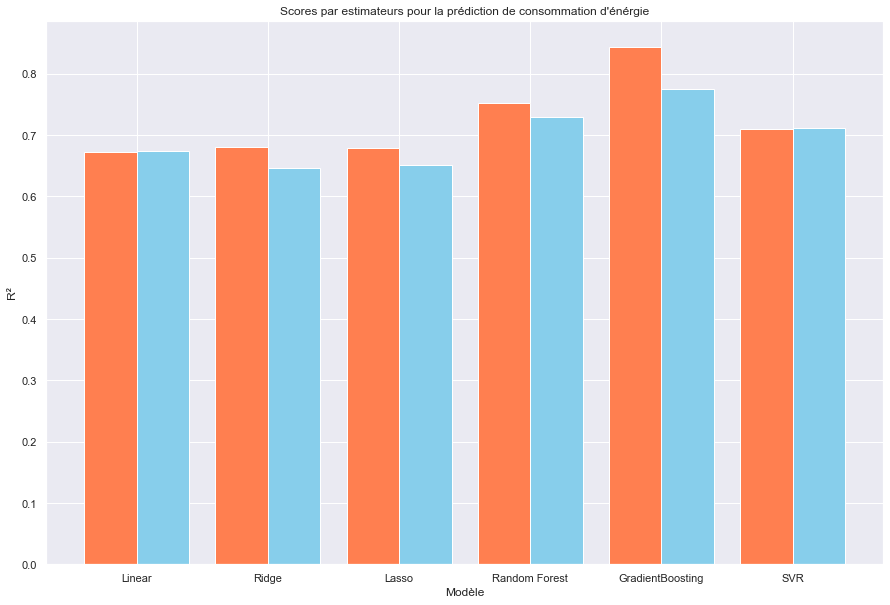

In [42]:
plot_training_vs_test(energy_df, True)

### Utilisation du XGBoost

pour le XGBoost, on va rajouter un paramètre pour l'early stopping, pour éviter d'overfitter le modèle

[0]	validation_0-rmse:1.0411	validation_1-rmse:1.02408
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.968959	validation_1-rmse:0.95509
[2]	validation_0-rmse:0.905788	validation_1-rmse:0.893737
[3]	validation_0-rmse:0.850896	validation_1-rmse:0.840668
[4]	validation_0-rmse:0.818632	validation_1-rmse:0.812806
[5]	validation_0-rmse:0.778659	validation_1-rmse:0.776026
[6]	validation_0-rmse:0.743937	validation_1-rmse:0.743267
[7]	validation_0-rmse:0.708723	validation_1-rmse:0.710434
[8]	validation_0-rmse:0.678491	validation_1-rmse:0.681572
[9]	validation_0-rmse:0.652375	validation_1-rmse:0.656618
[10]	validation_0-rmse:0.63313	validation_1-rmse:0.6392
[11]	validation_0-rmse:0.613107	validation_1-rmse:0.620781
[12]	validation_0-rmse:0.597767	validation_1-rmse:0.605612
[13]	validation_0-rmse:0.582548	validation_1-rmse:0.590717
[14]	validation_0-rmse:0.570593	

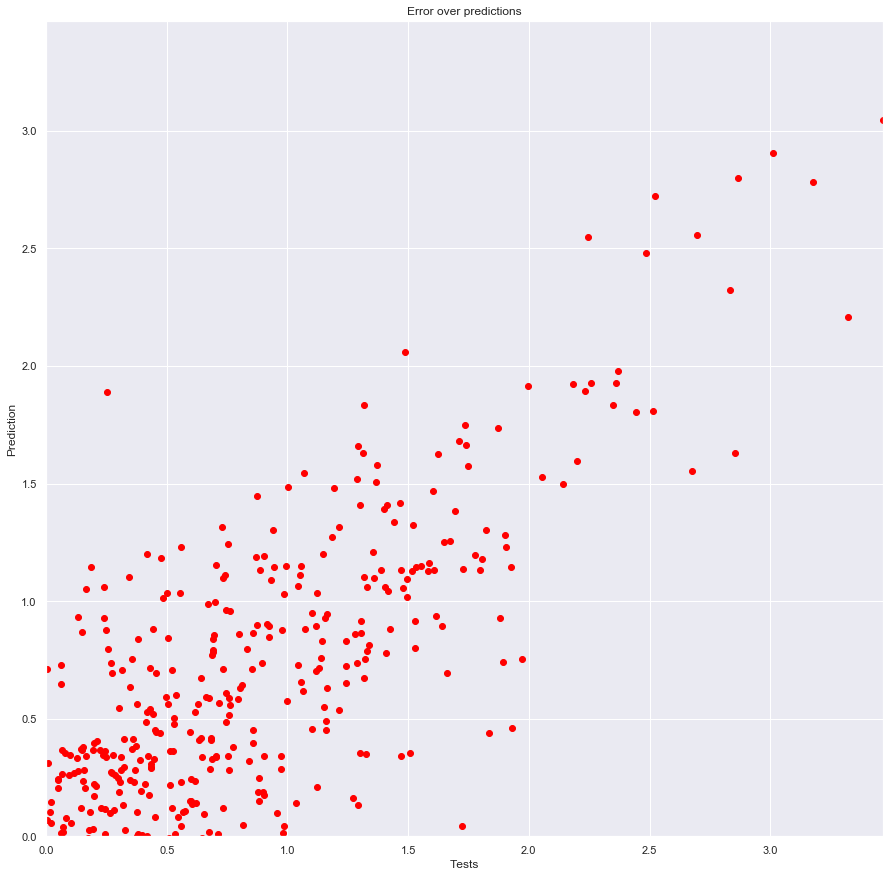

In [45]:
X_train, X_test, y_train, y_test = my_train_test_split(GHG_data, 'TotalGHGEmissions')

reg = XGBRegressor(random_state=42)

param_grid = {'nthread':[4], 
              'max_depth': range(2, 4),
              'min_child_weight': range(6,10),
              'subsample': np.linspace(0,1,6),
              'learning_rate':[0.1],
              'colsample_bytree':np.linspace(0,1,6), 
              'n_estimators': [1000]}
fit_params={'early_stopping_rounds':10, 
            'eval_metric' : 'rmse', 
            'eval_set' : [(X_train, y_train), (X_test, y_test)]}

grid = GridSearchCV(reg, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train, **fit_params)
print(grid.best_params_)
print('Early stopping at ' + str(grid.best_estimator_.best_ntree_limit))
print_regression_results(grid.best_estimator_,
                         X_train, X_test, y_train, y_test, color='red', result_df=gaz_df, row='XGBoost')


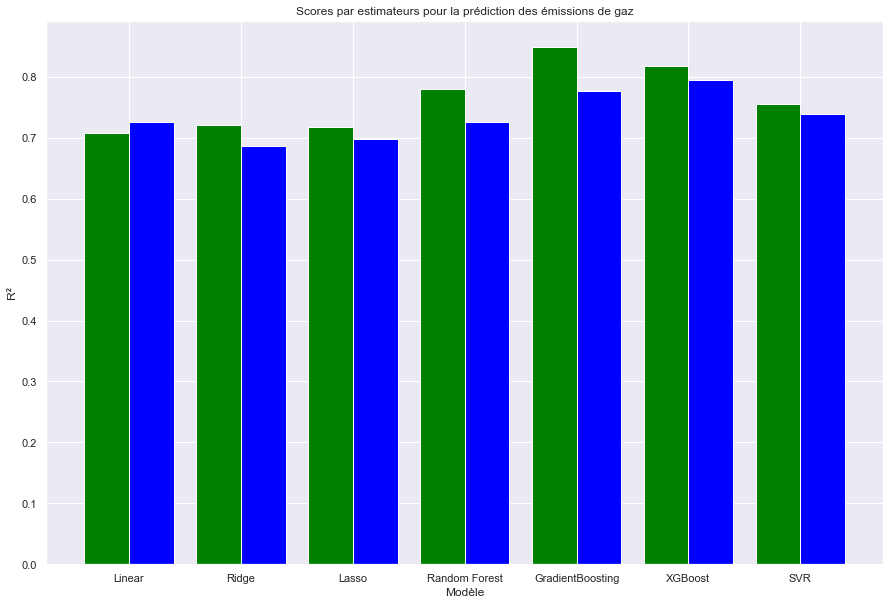

In [46]:
plot_training_vs_test(gaz_df, False)

In [47]:
# on va stocker cet estimateur qui est le meilleur pour l'istant 
gaz_estimator = grid.best_estimator_

[0]	validation_0-rmse:1.03177	validation_1-rmse:1.06391
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.964649	validation_1-rmse:0.99407
[2]	validation_0-rmse:0.929637	validation_1-rmse:0.957472
[3]	validation_0-rmse:0.874241	validation_1-rmse:0.897613
[4]	validation_0-rmse:0.842804	validation_1-rmse:0.866362
[5]	validation_0-rmse:0.81293	validation_1-rmse:0.834642
[6]	validation_0-rmse:0.789727	validation_1-rmse:0.808873
[7]	validation_0-rmse:0.764803	validation_1-rmse:0.787084
[8]	validation_0-rmse:0.729887	validation_1-rmse:0.749472
[9]	validation_0-rmse:0.712803	validation_1-rmse:0.733046
[10]	validation_0-rmse:0.695484	validation_1-rmse:0.717799
[11]	validation_0-rmse:0.668214	validation_1-rmse:0.687514
[12]	validation_0-rmse:0.645821	validation_1-rmse:0.663533
[13]	validation_0-rmse:0.625592	validation_1-rmse:0.642208
[14]	validation_0-rmse:0.6171

[137]	validation_0-rmse:0.421981	validation_1-rmse:0.471978
[138]	validation_0-rmse:0.421834	validation_1-rmse:0.472071
[139]	validation_0-rmse:0.421657	validation_1-rmse:0.471799
[140]	validation_0-rmse:0.421501	validation_1-rmse:0.471938
[141]	validation_0-rmse:0.420699	validation_1-rmse:0.471718
[142]	validation_0-rmse:0.420461	validation_1-rmse:0.471884
[143]	validation_0-rmse:0.420372	validation_1-rmse:0.471934
[144]	validation_0-rmse:0.420034	validation_1-rmse:0.47192
[145]	validation_0-rmse:0.419847	validation_1-rmse:0.471749
[146]	validation_0-rmse:0.419611	validation_1-rmse:0.471683
[147]	validation_0-rmse:0.419276	validation_1-rmse:0.471675
[148]	validation_0-rmse:0.419194	validation_1-rmse:0.471636
[149]	validation_0-rmse:0.418523	validation_1-rmse:0.471047
[150]	validation_0-rmse:0.4182	validation_1-rmse:0.470705
[151]	validation_0-rmse:0.417945	validation_1-rmse:0.47088
[152]	validation_0-rmse:0.417815	validation_1-rmse:0.470656
[153]	validation_0-rmse:0.417501	validation_

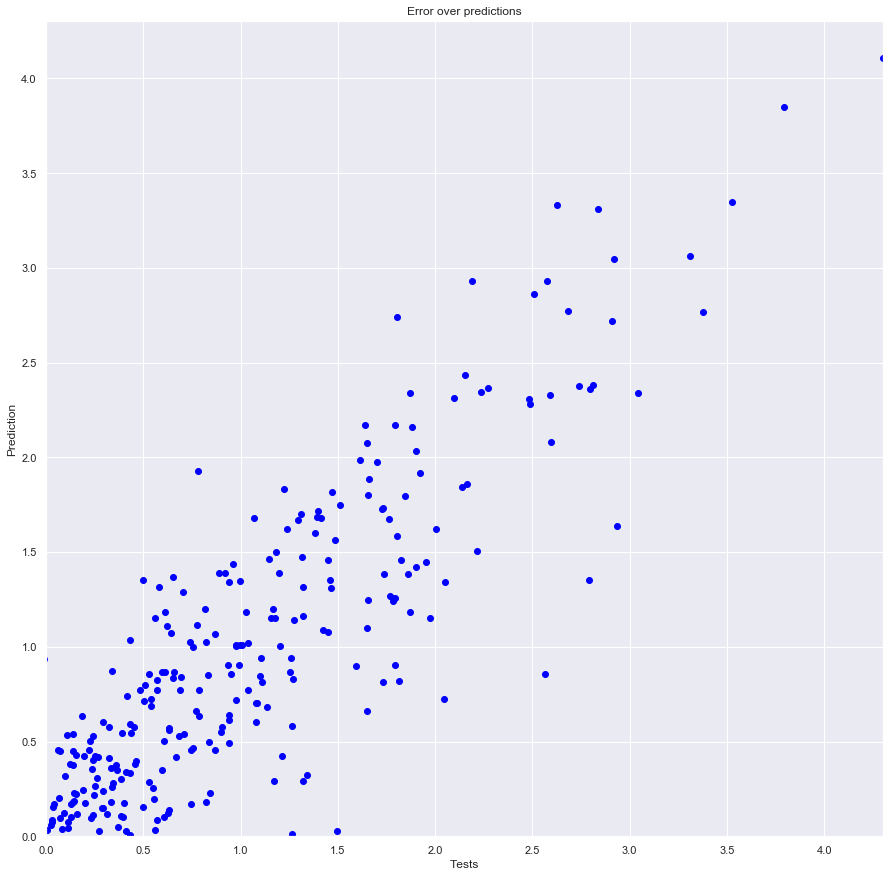

In [49]:
X_train, X_test, y_train, y_test = my_train_test_split(energy_data, 'SiteEnergyUseWN(kBtu)')

reg = XGBRegressor(random_state=42)

param_grid = {'nthread':[4], 
              'max_depth': range(2, 4),
              'min_child_weight': range(6,10),
              'subsample': np.linspace(0,1,6),
              'learning_rate':[0.1],
              'colsample_bytree':np.linspace(0,1,6), 
              'n_estimators': [200]}
fit_params={'early_stopping_rounds':10, 
            'eval_metric' : 'rmse', 
            'eval_set' : [(X_train, y_train), (X_test, y_test)]}

grid = GridSearchCV(reg, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train, **fit_params)
print(grid.best_params_)
print('Early stopping at ' + str(grid.best_estimator_.best_ntree_limit))
print_regression_results(grid.best_estimator_,
                         X_train, X_test, y_train, y_test, 
                         color='blue', result_df=energy_df, row='XGBoost')

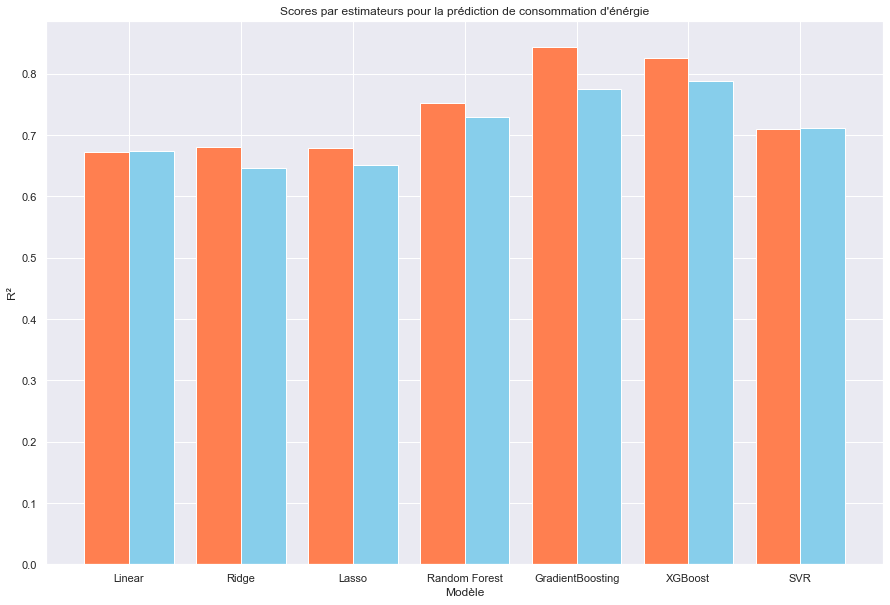

In [50]:
plot_training_vs_test(energy_df, True)

In [51]:
# on va stocker cet estimateur pour l'énérgie aussi qui est le meilleur pour l'istant 
energy_estimator = grid.best_estimator_

### Analyse des features les plus impactantes

In [52]:
# on va utiliser la librarie shap, pour visuellement voir l'impact de chaaque variable
def shap_values_explain(reg, data, target):
    X = data[set(list(data.columns)) -set([target])]
    explainer = shap.TreeExplainer(reg)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X)    


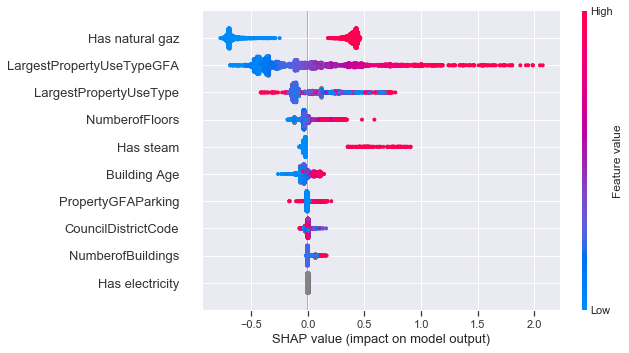

In [53]:
shap_values_explain(gaz_estimator, GHG_data, 'TotalGHGEmissions')

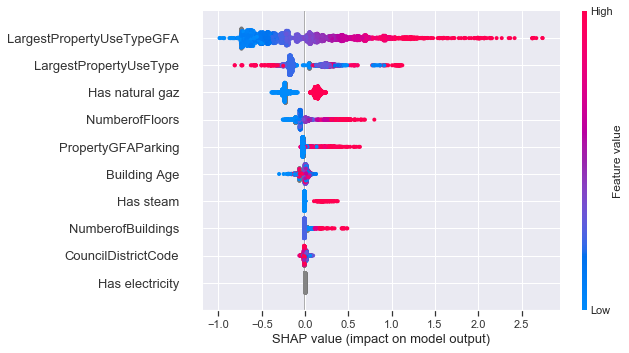

In [54]:
shap_values_explain(energy_estimator, energy_data, 'SiteEnergyUseWN(kBtu)')

### Test sur les données de 2015

In [55]:
GHG_data15=data15.drop(columns=['SiteEnergyUseWN(kBtu)','ENERGYSTARScore'])
energy_data15=data15.drop(columns=['TotalGHGEmissions','ENERGYSTARScore'])

In [59]:
def check_data_on_2015(reg, raw_data15, target, color='green'):
    
    raw_data15 = raw_data15.dropna(how='any')

    y15 = raw_data15[target]
    X15 = raw_data15[list(set(raw_data15.columns) - set([target]))] 
    
    y15_pred= reg.predict(X15)
    print('Data 2015 Score %f' % reg.score(X15, y15))
    
    plt.figure(figsize = (15,15))
    plt.title("Error over predictions")    
    plt.scatter(y15.values, y15_pred, color=color)
    plt.xlabel(target + ' tests')
    plt.ylabel(target + ' prediction')
    axes = plt.gca() 
    axes.set_xlim(0, max(max(y15.values), max(y15_pred)))
    axes.set_ylim(0, max(max(y15.values), max(y15_pred)))
    plt.show()


Data 2015 Score 0.798201


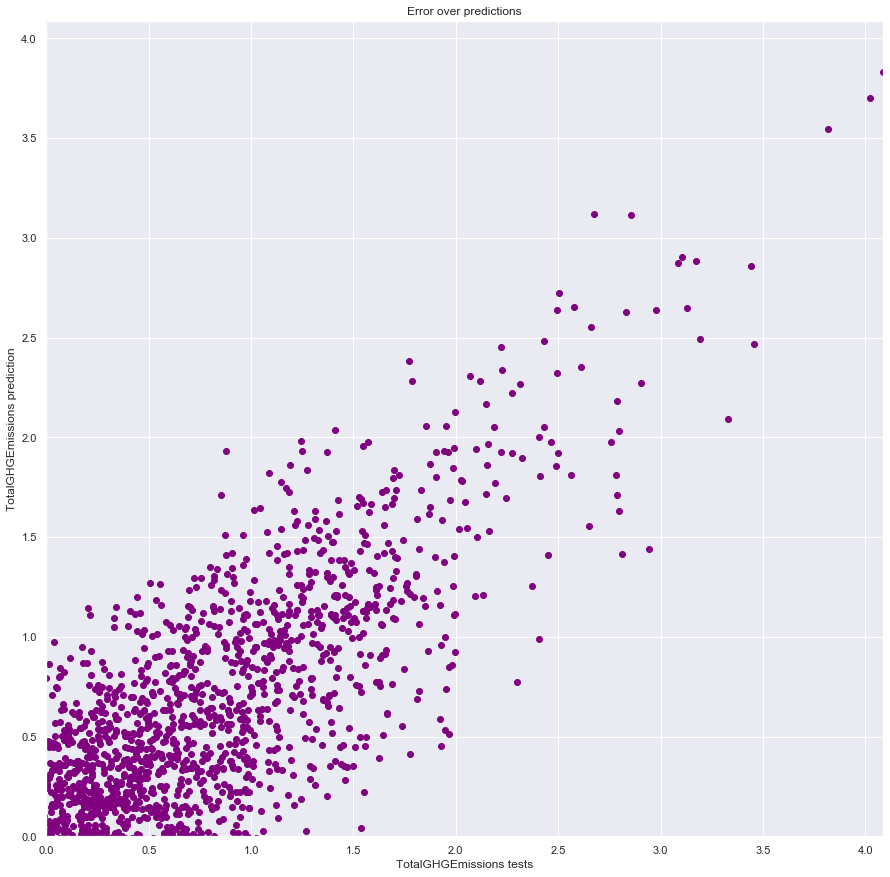

In [60]:
check_data_on_2015(gaz_estimator, GHG_data15, 'TotalGHGEmissions', color='purple')

Data 2015 Score 0.781574


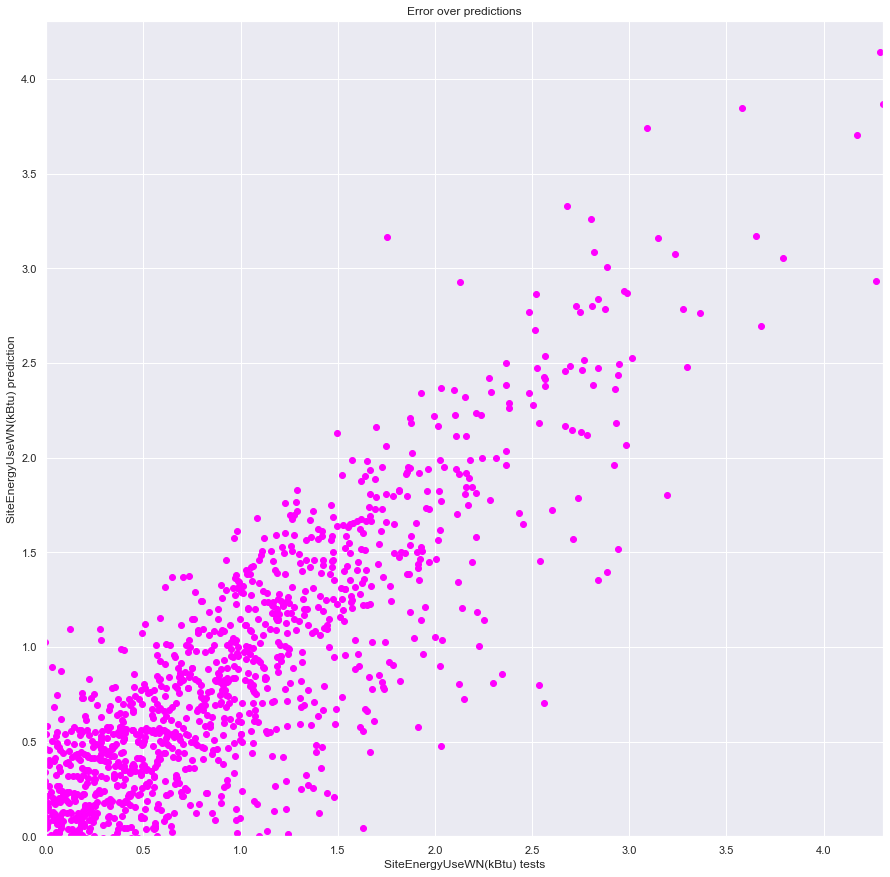

In [61]:
# Check for energy
check_data_on_2015(energy_estimator, energy_data15, 'SiteEnergyUseWN(kBtu)', color='magenta')

### Impact de la variable EnergyStarScore

[0]	validation_0-rmse:1.0281	validation_1-rmse:1.03237
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.953906	validation_1-rmse:0.955084
[2]	validation_0-rmse:0.901184	validation_1-rmse:0.903249
[3]	validation_0-rmse:0.841551	validation_1-rmse:0.842903
[4]	validation_0-rmse:0.788246	validation_1-rmse:0.788623
[5]	validation_0-rmse:0.744749	validation_1-rmse:0.743902
[6]	validation_0-rmse:0.703123	validation_1-rmse:0.703524
[7]	validation_0-rmse:0.670147	validation_1-rmse:0.670856
[8]	validation_0-rmse:0.638216	validation_1-rmse:0.63762
[9]	validation_0-rmse:0.610692	validation_1-rmse:0.610371
[10]	validation_0-rmse:0.587788	validation_1-rmse:0.589774
[11]	validation_0-rmse:0.568003	validation_1-rmse:0.569455
[12]	validation_0-rmse:0.54846	validation_1-rmse:0.549391
[13]	validation_0-rmse:0.533521	validation_1-rmse:0.535702
[14]	validation_0-rmse:0.51999

[137]	validation_0-rmse:0.326598	validation_1-rmse:0.380013
[138]	validation_0-rmse:0.326519	validation_1-rmse:0.379928
[139]	validation_0-rmse:0.326165	validation_1-rmse:0.380006
[140]	validation_0-rmse:0.325931	validation_1-rmse:0.379843
[141]	validation_0-rmse:0.325704	validation_1-rmse:0.379658
[142]	validation_0-rmse:0.325538	validation_1-rmse:0.379528
[143]	validation_0-rmse:0.325165	validation_1-rmse:0.378626
[144]	validation_0-rmse:0.324775	validation_1-rmse:0.378574
[145]	validation_0-rmse:0.324388	validation_1-rmse:0.378417
[146]	validation_0-rmse:0.324309	validation_1-rmse:0.378493
[147]	validation_0-rmse:0.324053	validation_1-rmse:0.378707
[148]	validation_0-rmse:0.323986	validation_1-rmse:0.378377
[149]	validation_0-rmse:0.323894	validation_1-rmse:0.378374
[150]	validation_0-rmse:0.3237	validation_1-rmse:0.378202
[151]	validation_0-rmse:0.323485	validation_1-rmse:0.378464
[152]	validation_0-rmse:0.323151	validation_1-rmse:0.378995
[153]	validation_0-rmse:0.322688	validatio

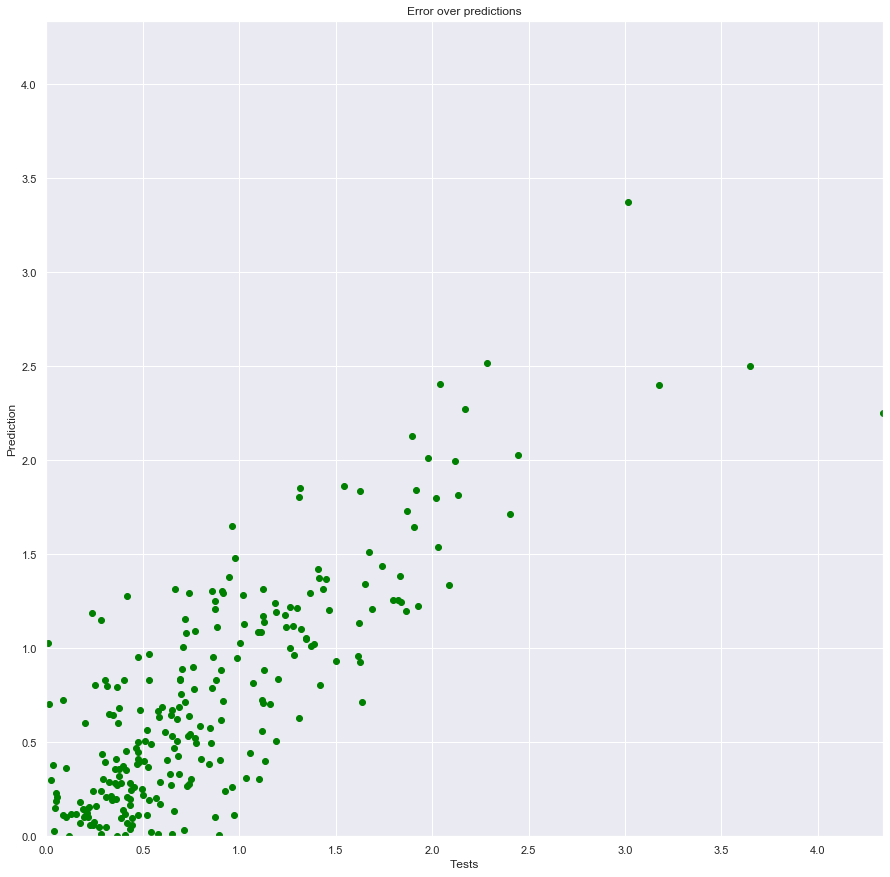

In [62]:
# on va partir sur un XGBoost vu que c'était notre meilleur estimateur

GHG_data15_starscore=data15.drop(columns=['SiteEnergyUseWN(kBtu)'])
energy_data15_starscore=data15.drop(columns=['TotalGHGEmissions'])

GHG_data_starscore=data.drop(columns=['SiteEnergyUseWN(kBtu)'])
energy_data_starscore=data.drop(columns=['TotalGHGEmissions'])

# Check for gaz first

X_train, X_test, y_train, y_test = my_train_test_split(GHG_data_starscore, 'TotalGHGEmissions')

reg = XGBRegressor(random_state=42)

param_grid = {'nthread':[4], 
              'max_depth': range(2,4),
              'min_child_weight': range(6,10),
              'subsample': np.linspace(0,1,6),
              'learning_rate':[0.1],
              'colsample_bytree':np.linspace(0,1,6), 
              'n_estimators': [1000]}
fit_params={'early_stopping_rounds':10, 
            'eval_metric' : 'rmse', 
            'eval_set' : [(X_train, y_train), (X_test, y_test)]}

grid = GridSearchCV(reg, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train, **fit_params)
print(grid.best_params_)
print_regression_results(grid.best_estimator_, X_train, X_test, y_train, y_test , color='green')

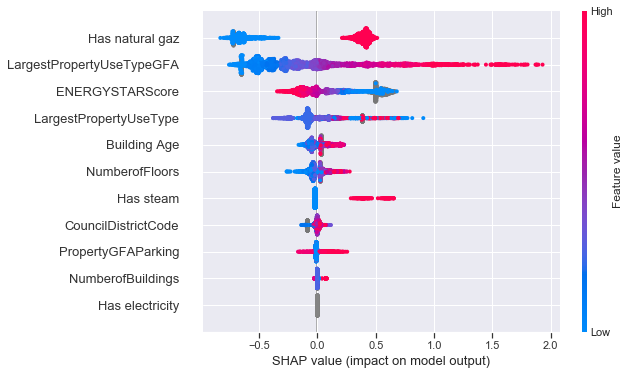

In [65]:
# On va regarder l'importance de la variabe  EnergyStarScore
shap_values_explain(grid.best_estimator_, GHG_data_starscore, 'TotalGHGEmissions')

Data 2015 Score 0.868159


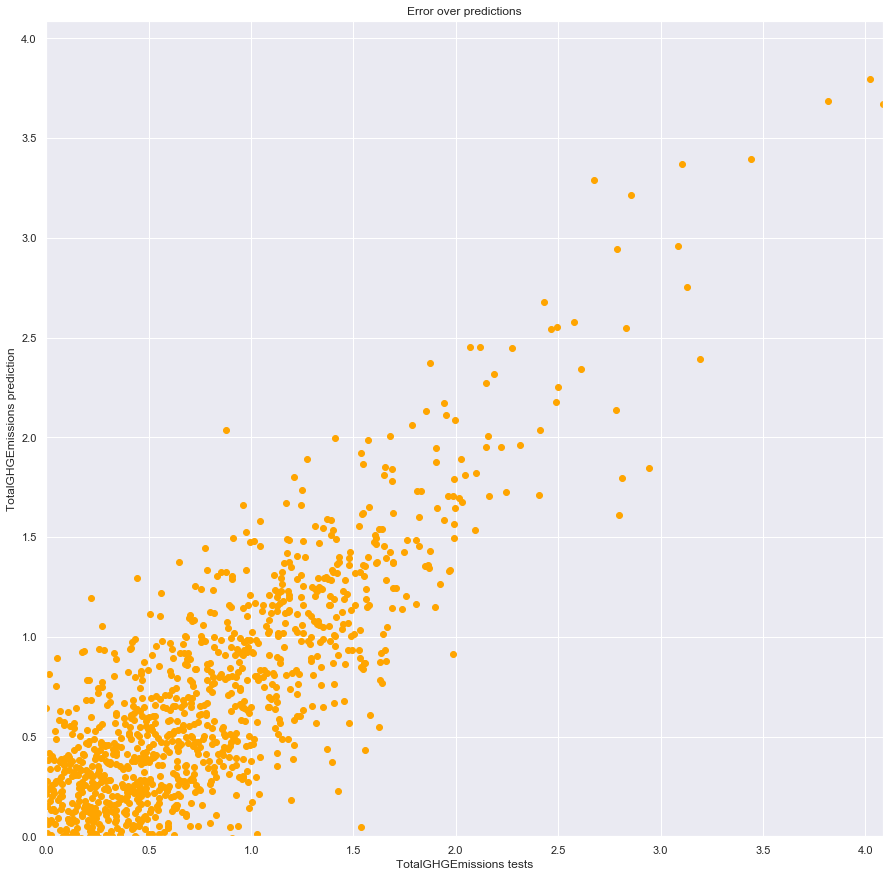

In [66]:
# On vérifie le score pour les données 2015
check_data_on_2015(grid.best_estimator_, GHG_data15_starscore, 'TotalGHGEmissions', color='orange')

[0]	validation_0-rmse:1.00856	validation_1-rmse:1.01226
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.935198	validation_1-rmse:0.942885
[2]	validation_0-rmse:0.871988	validation_1-rmse:0.8823
[3]	validation_0-rmse:0.815091	validation_1-rmse:0.82659
[4]	validation_0-rmse:0.774986	validation_1-rmse:0.789028
[5]	validation_0-rmse:0.739396	validation_1-rmse:0.758088
[6]	validation_0-rmse:0.69837	validation_1-rmse:0.71987
[7]	validation_0-rmse:0.660559	validation_1-rmse:0.683885
[8]	validation_0-rmse:0.6411	validation_1-rmse:0.662978
[9]	validation_0-rmse:0.616092	validation_1-rmse:0.641409
[10]	validation_0-rmse:0.599233	validation_1-rmse:0.625827
[11]	validation_0-rmse:0.571728	validation_1-rmse:0.599205
[12]	validation_0-rmse:0.547969	validation_1-rmse:0.576632
[13]	validation_0-rmse:0.533339	validation_1-rmse:0.564146
[14]	validation_0-rmse:0.515788	va

[137]	validation_0-rmse:0.265523	validation_1-rmse:0.330227
[138]	validation_0-rmse:0.265122	validation_1-rmse:0.330229
[139]	validation_0-rmse:0.264839	validation_1-rmse:0.330153
[140]	validation_0-rmse:0.264584	validation_1-rmse:0.330346
[141]	validation_0-rmse:0.264333	validation_1-rmse:0.330224
[142]	validation_0-rmse:0.264121	validation_1-rmse:0.330138
[143]	validation_0-rmse:0.264051	validation_1-rmse:0.330147
[144]	validation_0-rmse:0.263846	validation_1-rmse:0.330339
[145]	validation_0-rmse:0.263652	validation_1-rmse:0.330356
[146]	validation_0-rmse:0.263399	validation_1-rmse:0.330189
[147]	validation_0-rmse:0.262584	validation_1-rmse:0.329085
[148]	validation_0-rmse:0.262341	validation_1-rmse:0.328921
[149]	validation_0-rmse:0.262162	validation_1-rmse:0.328859
[150]	validation_0-rmse:0.261997	validation_1-rmse:0.328797
[151]	validation_0-rmse:0.261834	validation_1-rmse:0.328728
[152]	validation_0-rmse:0.261373	validation_1-rmse:0.328709
[153]	validation_0-rmse:0.261161	validat

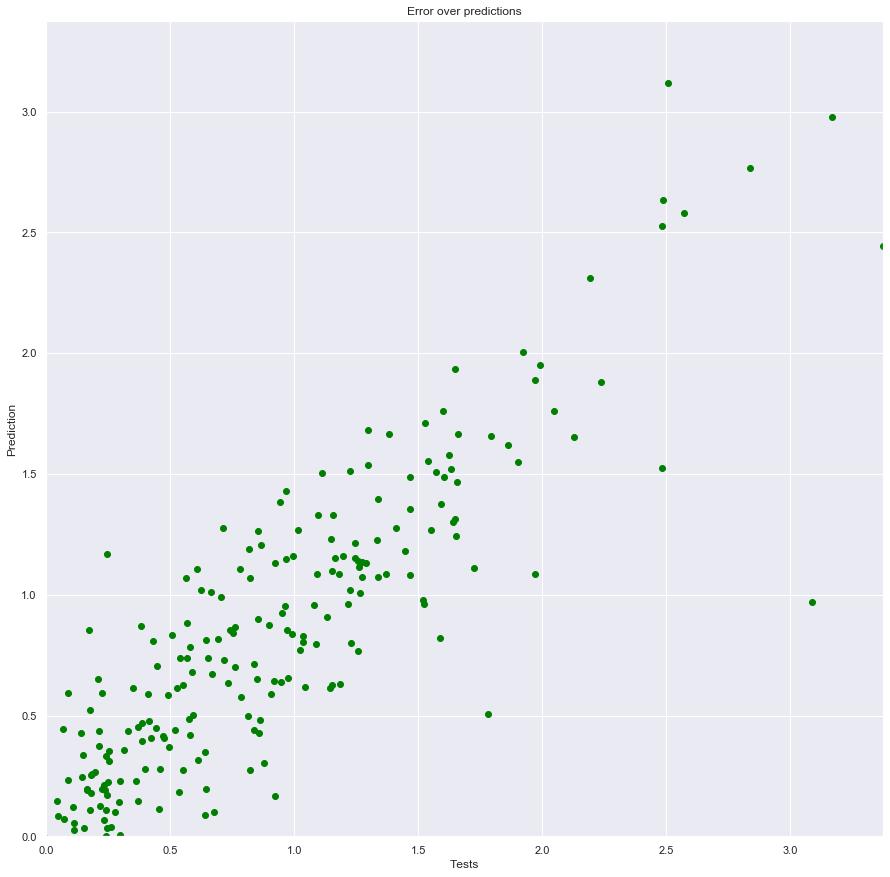

In [68]:
# check pour les émissions de  gaz
X_train, X_test, y_train, y_test = my_train_test_split(energy_data_starscore, 'SiteEnergyUseWN(kBtu)')

reg = XGBRegressor(random_state=42)

param_grid = {'nthread':[4], 
              'max_depth': range(2,4),
              'min_child_weight': range(6,10),
              'subsample': np.linspace(0,1,6),
              'learning_rate':[0.1],
              'colsample_bytree':np.linspace(0,1,6), 
              'n_estimators': [1000]}
fit_params={'early_stopping_rounds':10, 
            'eval_metric' : 'rmse', 
            'eval_set' : [(X_train, y_train), (X_test, y_test)]}

grid = GridSearchCV(reg, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train, y_train, **fit_params)
print(grid.best_params_)
print_regression_results(grid.best_estimator_, X_train, X_test, y_train, y_test , color='green')


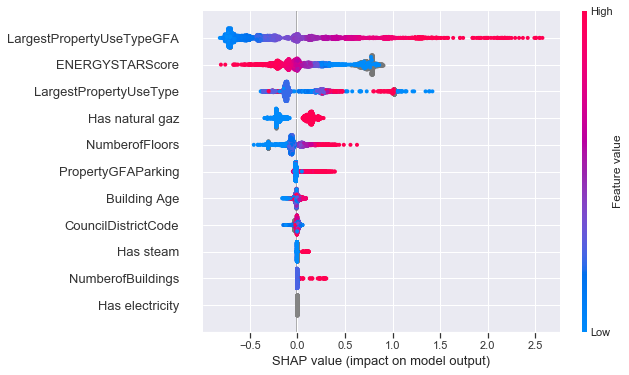

In [69]:
# On va regarder l'importance de la variabe  EnergyStarScore pour la consommation d'éléctricité
shap_values_explain(grid.best_estimator_, energy_data_starscore, 'SiteEnergyUseWN(kBtu)')

Data 2015 Score 0.895470


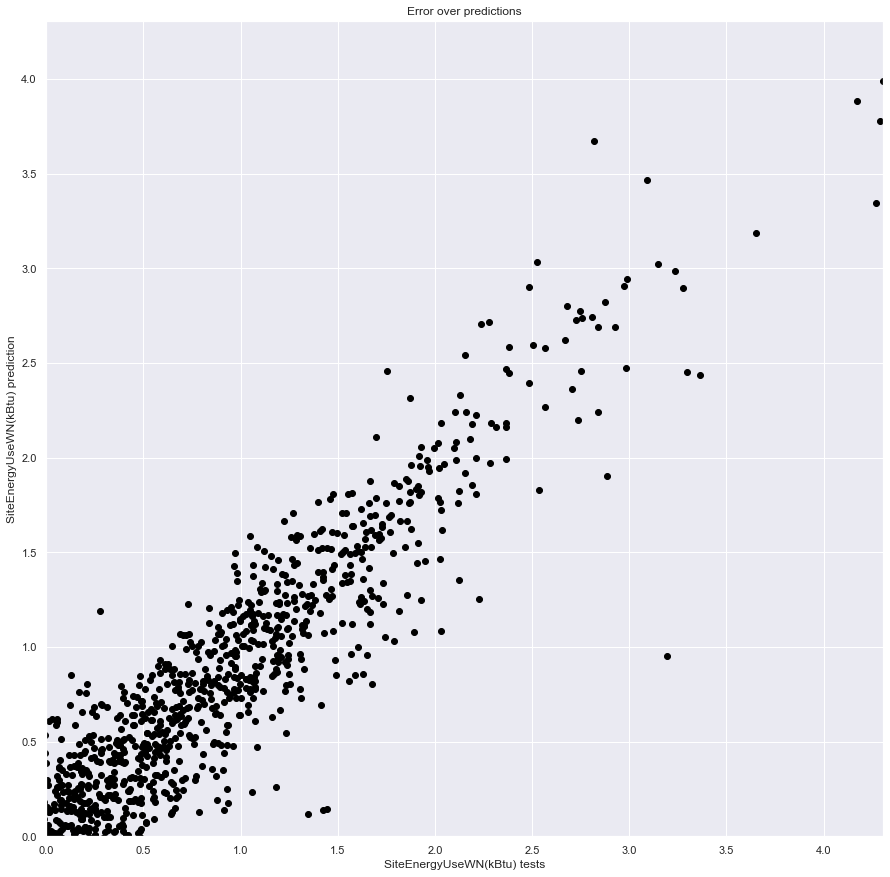

In [70]:
# On vérifie l'impact de ce novuel estimateur sur les données 2015
check_data_on_2015(grid.best_estimator_, energy_data15_starscore, 'SiteEnergyUseWN(kBtu)', color='black')

### Conclusion 
    - Le Meilleur estimateur trouvé est XGBoost pour l'estimation des émissions de gaz et de la consomation d'énérgie
    - Le modèle semble bien marcher sur un nouveau set de données 
    - Avec la variable EnergySTARScore on obtient encore une meilleure approximation